**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

**Data Preprocessing**

Read data from csv files

In [2]:
# in the CSV files, it should be included a 'Label' column
# at the first experiment, the trained model predicted wrongly on the test set because of the different scaling range in test and training set
train_raw = pd.read_csv('sample_data/chicken_train.csv')
#test_raw = pd.read_csv('sample_data/chicken_test.csv')
print(train_raw.shape)
#print(test_raw.shape)

(4640, 3)


plot the input data

1       23.77
2       23.55
3       23.49
4       23.54
5       23.53
        ...  
4635    26.89
4636    26.91
4637    26.95
4638    26.98
4639    26.98
Name: Temp, Length: 4639, dtype: float64


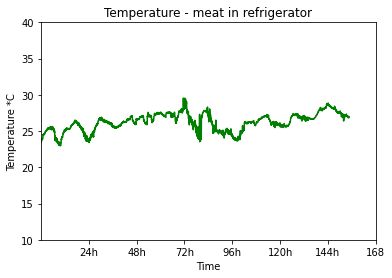

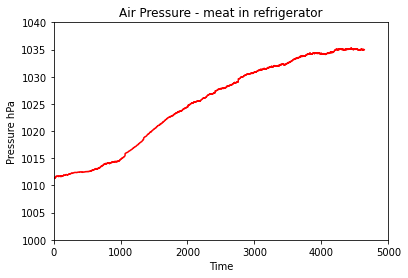

In [3]:
dataFrame = pd.DataFrame(train_raw, columns=["Temp", "Chicken", "Label"])

temperature = dataFrame.Temp[1:5000]
print(temperature)
meat = dataFrame.Chicken[1:5000]
fig, ax = plt.subplots()
labels = ['24h', '48h', '72h', '96h', '120h', '144h', "168"]
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([720, 1440, 2160, 2880, 3600, 4320, 5040])
    ax.set_xticklabels(labels)
  # temp
plt.title('Temperature - meat in refrigerator')
plt.xlim(0, 5000)
plt.ylim(10, 40)
set_axis_style(ax, labels)
plt.plot(temperature, color='green')
plt.xlabel("Time")
plt.ylabel("Temperature *C")
plt.show()

plt.title('Air Pressure - meat in refrigerator')
plt.xlim(0,5000)
plt.ylim(1000, 1040)
set_axis_style(ax, labels)
plt.plot(meat, color='red')
plt.xlabel("Time")
plt.ylabel("Pressure hPa")
plt.show()


Encode labels and features

In [4]:
#def encoder(train, test):
def encoder(train):
  label_encoder = LabelEncoder().fit(train.Label)
  train_labels = label_encoder.transform(train.Label)
  classes = list(label_encoder.classes_)

  #label_encoder = LabelEncoder().fit(test.Label)
  #test_labels = label_encoder.transform(test.Label)

  train = train.drop(['Label'], axis=1)
  #test = test.drop(['Label'], axis=1)

  #return train, test, train_labels, test_labels, classes
  return train, train_labels, classes

# run function
#train, test, train_labels, test_labels, classes = encoder(train_raw, test_raw)
train, train_labels, classes = encoder(train_raw)
print(len(train_labels))

4640


standardize training features

In [5]:
# data standardize function
#def data_standardize(train, test):
def data_standardize(train):
  scaler = StandardScaler().fit(train.values)
  scaled_train = scaler.transform(train.values)
  #scaler = StandardScaler().fit(test.values)
  #scaled_test = scaler.transform(test.values)
  #return scaled_train, scaled_test
  return scaled_train

#scaled_train, scaled_test = data_standardize(train, test)
scaled_train = data_standardize(train)



split train data into train and validation

In [6]:

val_percent = 0.2
test_percent = 0.5 # 50% of validation set

# shuffle training set
def split_data(data, label, percent):
  split_object = StratifiedShuffleSplit(test_size=percent, random_state=10)
  for A_i, B_i in split_object.split(data, label):
    A_data, B_data = data[A_i], data[B_i]
    A_label, B_label = label[A_i], label[B_i]
  return A_data, B_data, A_label, B_label

X_train, X_exam, y_train, y_exam = split_data(scaled_train, train_labels, val_percent)
X_valid, X_test, y_valid, y_test = split_data(X_exam, y_exam, test_percent)

print("train size:", len(y_train))
print("validation size:", len(y_valid))
print("test size:", len(y_test))


train size: 3712
validation size: 464
test size: 464


In [7]:
# check number of samples
print(len(y_test))
i = 0

for a in y_test:
  if a == 0:
    i=i+1

print(i)

print(classes)


464
62
['Freshness', 'Rotting', 'Warning']


Reshape data into input tensor

In [8]:
# imaging that we will reshape the input data from 2D to 3D, the number of data row -> oy, the number of features -> ox, the number of texture -> oz
# in this case, we set texture_number=2 by default because of temperature and pressure
# define feature to use for reshaping input tensor( number of column in 1 perspective)
nb_features = 2
nb_class = len(classes)
y_train_onehot = np_utils.to_categorical(y_train, nb_class)
y_valid_onehot = np_utils.to_categorical(y_valid, nb_class)

def input_reshape(scaled_data, features_number, texture_number=1):
  input_tensor = np.zeros((len(scaled_data), features_number, texture_number))
  input_tensor[:, :, 0] = scaled_data[:, :features_number]
  #input_tensor[:, :, 1] = scaled_data[:, features_number:2]
  return input_tensor

train_input = input_reshape(X_train, nb_features)
val_input = input_reshape(X_valid, nb_features)
test_input = input_reshape(X_test, nb_features)

print(train_input.shape, val_input.shape)


(3712, 2, 1) (464, 2, 1)


**Training 1D-CNN**

prepare for k-fold training

In [ ]:
# K-Fold training with 1-D CNN model
num_folds = 5
kfold = KFold(n_splits=num_folds,random_state=1, shuffle=True)
acc_per_fold=[]
loss_per_fold=[]
fold_no=1
for train_k, test_k in kfold.split(train_input, y_train_onehot):
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, input_shape=(nb_features, 1)))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(nb_class))
  model.add(Activation('softmax'))
  sgd = SGD(lr=0.001, nesterov=True, decay=1e-6, momentum=0.9)
  model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
  nb_epoch = 100
  history = model.fit(train_input[train_k], y_train_onehot[train_k], epochs=nb_epoch, batch_size=32, verbose=1)
  scores = model.evaluate(train_input[test_k], y_train_onehot[test_k], verbose=0)
  acc_per_fold.append(scores[1]*100)
  loss_per_fold.append(scores[0])
print(f'Accuracy: {np.mean(acc_per_fold)}(+-{np.std(acc_per_fold)})')


Re-train on entire training dataset to avoid missing data

In [ ]:
  # After K-Fold Traning step, choose the best model and re-train on entire dataset to avoid missing data.
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, input_shape=(nb_features, 1)))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(nb_class))
  model.add(Activation('softmax'))
  sgd = SGD(lr=0.001, nesterov=True, decay=1e-6, momentum=0.9)
  model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
  nb_epoch = 500
  history_CNN = model.fit(train_input, y_train_onehot, epochs=nb_epoch,validation_data = (val_input, y_valid_onehot), batch_size=32, verbose=1)


**Predict on test set and evaluate model**

Define plot confusion matrix function

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion Matrix',
                        cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Plot accuracy and loss values

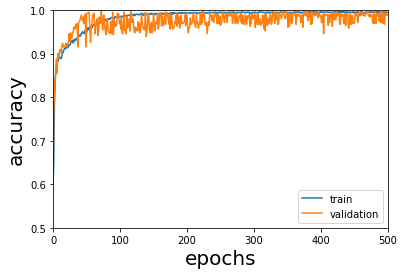

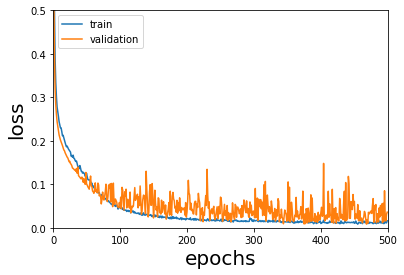

In [11]:
# summarize history for accuracy
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.ylim(0.5,1)
plt.xlim(0, 500)
#plt.title('model accuracy', fontsize='20')
plt.ylabel('accuracy', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.ylim(0, 0.5)
plt.xlim(0, 500)
#plt.title('CNN model - Pork', fontsize='20')
plt.ylabel('loss', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Plot CNN Confusion matrix

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization
[[ 58   0   4]
 [  0 284   0]
 [  0   1 117]]


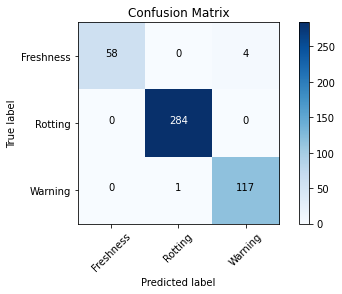

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_label_val = model.predict_classes(val_input)
cm = confusion_matrix(y_valid, predicted_label_val)
plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues)

**Training SVM**

In [13]:
from sklearn import svm


Fit SVM with different sorts of kernel

In [14]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(scaled_train, train_labels)

rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(scaled_train, train_labels)

poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(scaled_train, train_labels)

sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(scaled_train, train_labels)


Create a grid and draw svm boundaries and data

In [15]:
# Step size in the mesh
h = .01

# create the mesh
print(scaled_train.shape)

x_min, x_max = scaled_train[:, 0].min() - 1, scaled_train[:, 0].max() + 1
y_min, y_max = scaled_train[:, 1].min() - 1, scaled_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create the title that will be shown on the plot
titles = ['Linear kernel', 'RBF kernel', 'Polynomial kernel', 'Sigmoid kernel']




(4640, 2)


In [16]:
print(len(train_labels))
i = 0

for a in train_labels:
  if a == 2:
    i=i+1

print(i)

print(classes)

4640
1179
['Freshness', 'Rotting', 'Warning']


[0 0 0 ... 1 1 1]
['Freshness', 'Rotting', 'Warning']


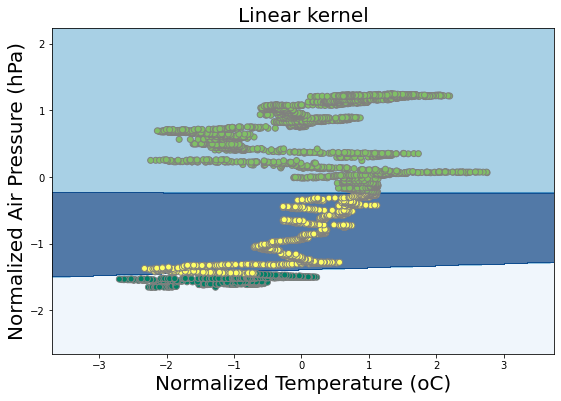

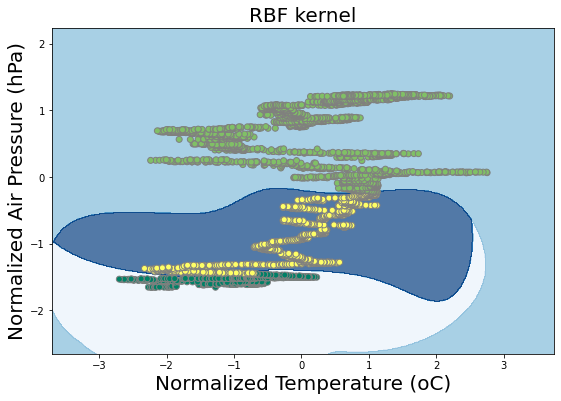

In [17]:
print(train_labels)
print(classes)
for i, clf in enumerate((linear, rbf)):
    #defines how many plots: 2 rows, 2columns=> leading to 4 plots
    plt.figure(figsize=(9,6))
    
    #plt.subplot(2, 2, i + 1) #i+1 is the index
    #space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.7)
    # Plot also the training points
    plt.scatter(scaled_train[:, 0], scaled_train[:, 1], c=train_labels, cmap=plt.cm.summer, edgecolors='grey')

    plt.xlabel('Normalized Temperature (oC)', fontsize='20')
    plt.ylabel('Normalized Air Pressure (hPa)', fontsize='20')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
   # plt.xticks(())
   # plt.yticks(())
    plt.title(titles[i], fontsize='20')
    plt.show()



Print the accuracy 

In [18]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)


In [19]:
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)



In [20]:
print(accuracy_lin)
print(accuracy_poly)
print(accuracy_rbf)
print(accuracy_sig)


1.0
0.9655172413793104
0.9978448275862069
0.790948275862069


Plot Confusion Matrix of SVM

Confusion matrix, without normalization
[[ 62   0   0]
 [  0 283   1]
 [  0  15 103]]


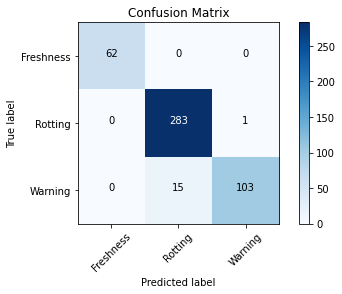

In [21]:
cm2 = confusion_matrix(y_test, poly_pred)
plot_confusion_matrix(cm2, classes, cmap=plt.cm.Blues)


**Training MLP**

In [ ]:
# build a MLP model
from keras import Input
print(scaled_train.shape)
print(train_labels.shape)
MLP = Sequential()
MLP.add(Dense(64, activation='relu', input_shape=(2,1)))
print(MLP.input_shape)
MLP.add(Flatten())
MLP.add(Dense(256, activation='relu'))
MLP.add(Dense(128, activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(nb_class))
MLP.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
MLP.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_MLP = MLP.fit(train_input, y_train_onehot, epochs=500,validation_data = (val_input, y_valid_onehot), batch_size=32, verbose=1)

**Evaluate MLP model and predict on Test Set**

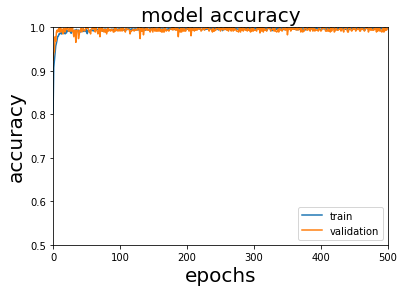

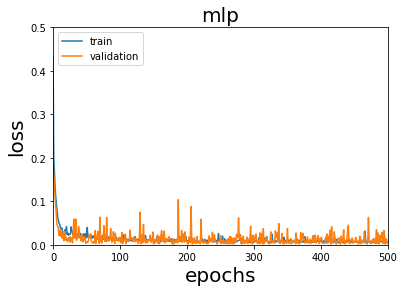

In [23]:
# summarize history for accuracy
plt.plot(history_MLP.history['accuracy'])
plt.plot(history_MLP.history['val_accuracy'])
plt.ylim(0.5,1)
plt.xlim(0, 500)
plt.title('model accuracy', fontsize='20')
plt.ylabel('accuracy', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.ylim(0, 0.5)
plt.xlim(0, 500)
plt.title('mlp', fontsize='20')
plt.ylabel('loss', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Plot Confusion matrix of MLP model

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization
[[ 62   0   0]
 [  0 282   2]
 [  0   0 118]]


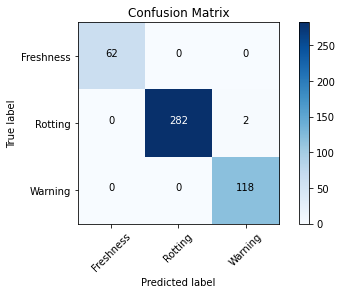

In [24]:
MLP_predict = MLP.predict_classes(test_input)
cm = confusion_matrix(y_test, MLP_predict)
plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues)

**LSTM Training**

In [ ]:
# build model
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, input_shape=(2, 1)))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dense(nb_class, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nb_epochs = 500
history_LSTM= model_LSTM.fit(train_input, y_train_onehot, epochs=nb_epochs, validation_data = (val_input, y_valid_onehot), batch_size=32, verbose=1)



**LSTM evaluate and predict on test set**

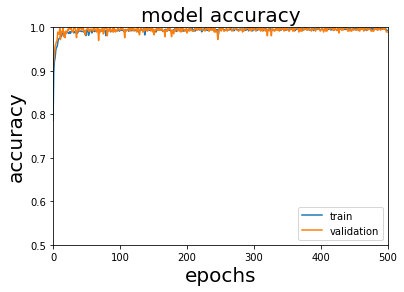

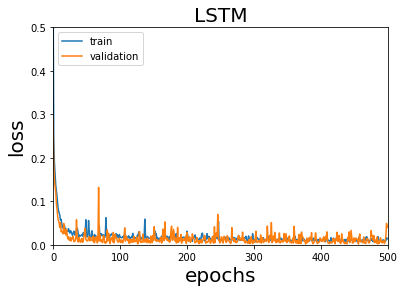

In [26]:
# summarize history for accuracy
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.ylim(0.5,1)
plt.xlim(0, 500)
plt.title('model accuracy', fontsize='20')
plt.ylabel('accuracy', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.ylim(0, 0.5)
plt.xlim(0, 500)
plt.title('LSTM', fontsize='20')
plt.ylabel('loss', fontsize='20')
plt.xlabel('epochs', fontsize='20')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

LSTM plot Confusion matrix

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization
[[ 62   0   0]
 [  0 284   0]
 [  0   1 117]]


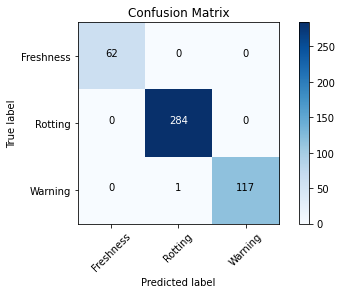

In [27]:
LSTM_predict = model_LSTM.predict_classes(test_input)
cm = confusion_matrix(y_test, LSTM_predict)
plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues)